In [1]:
import numpy as np
import bayesbay as bb
import matplotlib.pyplot as plt
np.random.seed(30)

In [2]:
# dimensions and true coefficients
N_DIMS = 4
M0, M1, M2, M3 = 20, -10, -3, 1

# data and noise
N_DATA = 15
DATA_X = np.linspace(-5, 10, N_DATA)
DATA_NOISE_STD = 20

In [3]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

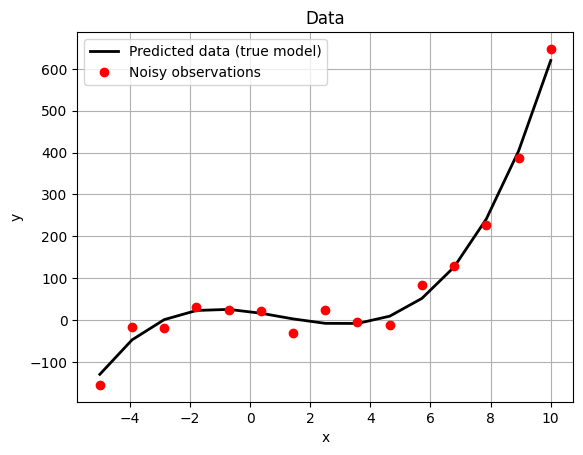

In [4]:
fig, ax = plt.subplots()
ax.set_title('Data')
ax.plot(DATA_X, y, 'k', lw=2, label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()
plt.show()

In [5]:
m0 = bb.parameters.GaussianParameter(name="m0", mean=20, std=1, perturb_std=0.5)
m1 = bb.parameters.UniformParameter(name="m1", vmin=-13, vmax=-7, perturb_std=0.4)
m2 = bb.parameters.UniformParameter(name="m2", vmin=-10, vmax=4, perturb_std=0.5)
m3 = bb.parameters.GaussianParameter(name="m3", mean=1, std=0.1, perturb_std=0.1)

In [6]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=1, 
    parameters=[m0, m1, m2, m3], 
)
parameterization = bb.parameterization.Parameterization(param_space)

In [7]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = [state["my_param_space"][f"m{i}"] for i in range(N_DIMS)]
    return np.squeeze(fwd_operator @ m) # dpred = G m

In [8]:
target = bb.Target("my_data", 
                   y_noisy, 
                   std_min=0, 
                   std_max=40, 
                   std_perturb_std=4,
                   noise_is_correlated=False)

In [9]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=10, 
    n_cpus=10
)
inversion.run(
    sampler=None, 
    n_iterations=100_000, 
    burnin_iterations=10_000, 
    save_every=500, 
    verbose=False, 
)

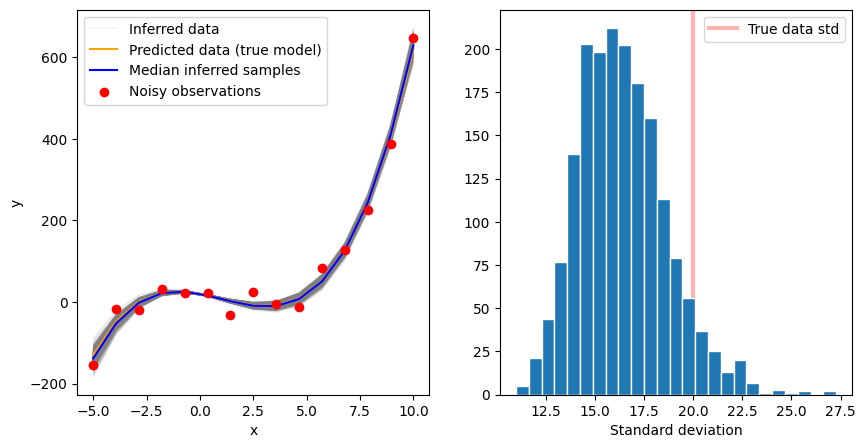

In [10]:
results = inversion.get_results()

coefficients_samples = np.squeeze(np.array([results[f"m{i}"] for i in range(N_DIMS)]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
y_pred = np.array(results["dpred"])
ax1.plot(DATA_X, y_pred[0], c='gray', lw=0.3, alpha=0.3, label="Inferred data")
ax1.plot(DATA_X, y_pred[1:].T, c='gray', lw=0.3, alpha=0.3)
ax1.plot(DATA_X, y, c='orange', label='Predicted data (true model)')
ax1.plot(DATA_X, np.median(y_pred, axis=0), c="blue", label='Median inferred samples')
ax1.scatter(DATA_X, y_noisy, c='r', label='Noisy observations', zorder=3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

ax2.axvline(x=DATA_NOISE_STD, color='r', lw=3, alpha=0.3, label='True data std')
ax2.hist(results['my_data.std'], bins=25, ec='w', zorder=100)
ax2.set_xlabel('Standard deviation')
ax2.legend()
plt.show()

/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1800) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


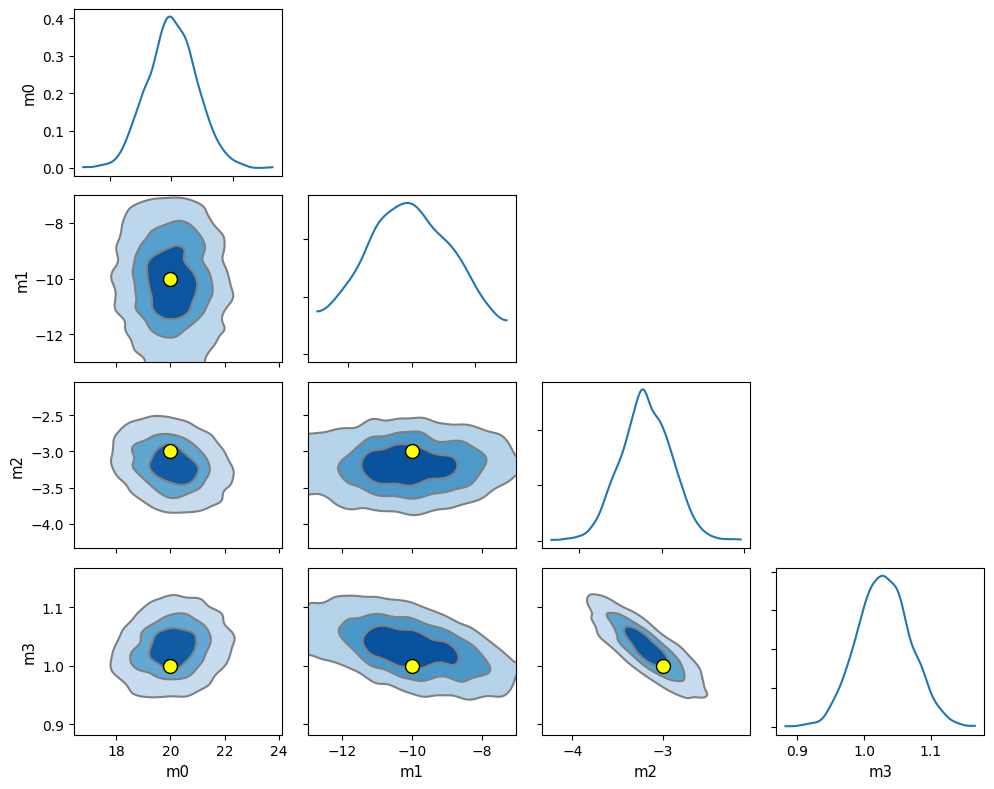

In [11]:
import arviz as az

fig, axes = plt.subplots(4, 4, figsize=(10, 8))
results_coefficients = {k: v for k, v in results.items() if k not in ['dpred', 'my_data.std']}
_ = az.plot_pair(
    results_coefficients,
    marginals=True,
    reference_values={'m0': M0, 'm1': M1, 'm2': M2, 'm3': M3},
    reference_values_kwargs={'color': 'yellow',
                             'ms': 10},
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
        },
    ax=axes,
    textsize=10
    )
plt.tight_layout()